<a href="https://colab.research.google.com/github/u2200579/Image-Classification/blob/main/DM_(Prediction_of_Cell_Composition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, classification_report, r2_score
from scipy.stats import entropy as en, pearsonr, spearmanr
import skimage
import skimage.measure 
from skimage.color import rgb2hed, hed2rgb, rgb2gray
from skimage.io import imread
from skimage import feature, img_as_ubyte
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer

Importing and Reading Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/images.npy" "images"
!cp "/content/drive/My Drive/counts.csv" "counts"
!cp "/content/drive/My Drive/split.txt" "split"

In [ ]:
X = np.load("images")#read images
Y = pd.read_csv('counts')#read cell counts
F = np.loadtxt('split')#read fold information

**Visualising and analysing samples in each Fold**

In [ ]:
#i
a=np.sum(np.array(F) > 2, axis=0)
b=np.sum(np.array(F) < 2, axis=0)
c = (4981-a-b)
print('First Fold:', b,'Second Fold:', c,'Third Fold:', a)
#There are 4981 examples in total

First Fold: 1622 Second Fold: 1751 Third Fold: 1608


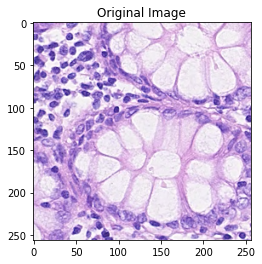

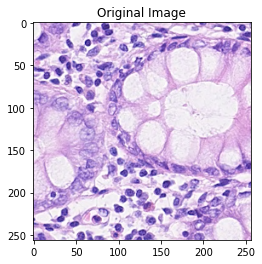

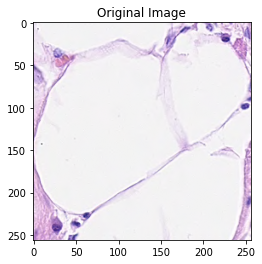

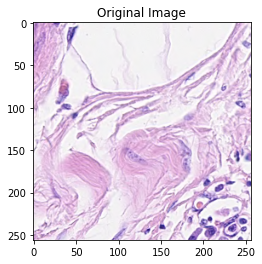

In [ ]:
for i in range(10,14): #for images 10 - 14 plot original and H channel 
    I = X[i]/255.0 #read sample image and rescale pixel range in it
    plt.imshow(I);plt.title('Original Image');plt.show()

In [ ]:
Y.insert(6,"Fold",F)

In [ ]:
#MCC stands for Max Cell COUNT
Fold1 = Y[Y["Fold"] == 1.0]
print('neutrophil MCC:', Fold1["neutrophil"].max(),'epithelial MCC:', Fold1["epithelial"].max(),'lymphocyte MCC:', Fold1["lymphocyte"].max() ,'plasma MCC:', Fold1["plasma"].max(),'eosinophil MCC:', Fold1["eosinophil"].max(),'connective MCC:', Fold1["connective"].max())

neutrophil MCC: 50 epithelial MCC: 253 lymphocyte MCC: 264 plasma MCC: 62 eosinophil MCC: 19 connective MCC: 104


In [ ]:
Fold2 = Y[Y["Fold"] == 2.0]
print('neutrophil MCC:', Fold2["neutrophil"].max(),'epithelial MCC:', Fold2["epithelial"].max(),'lymphocyte MCC:', Fold2["lymphocyte"].max() ,'plasma MCC:', Fold2["plasma"].max(),'eosinophil MCC:', Fold2["eosinophil"].max(),'connective MCC:', Fold2["connective"].max())

neutrophil MCC: 48 epithelial MCC: 169 lymphocyte MCC: 450 plasma MCC: 66 eosinophil MCC: 25 connective MCC: 102


In [ ]:
Fold3 = Y[Y["Fold"] == 3.0]
print('neutrophil MCC:', Fold3["neutrophil"].max(),'epithelial MCC:', Fold3["epithelial"].max(),'lymphocyte MCC:', Fold3["lymphocyte"].max() ,'plasma MCC:', Fold3["plasma"].max(),'eosinophil MCC:', Fold3["eosinophil"].max(),'connective MCC:', Fold3["connective"].max())

neutrophil MCC: 18 epithelial MCC: 181 lymphocyte MCC: 293 plasma MCC: 90 eosinophil MCC: 16 connective MCC: 99


**Cell Count vs Cell Type**

<function matplotlib.pyplot.show(*args, **kw)>

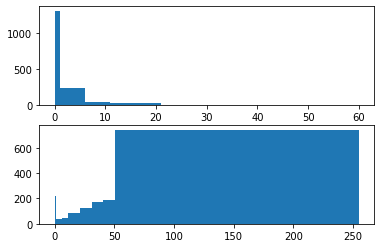

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
(n, bins, patches) = ax1.hist(Fold1["neutrophil"],[0,1,6,11,21,31,41,51,60])
(n1, bins, patches) = ax2.hist(Fold1["epithelial"],[0,1,6,11,21,31,41,51,255])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

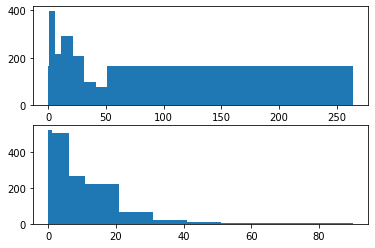

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
(n2, bins, patches) = ax1.hist(Fold1["lymphocyte"],[0,1,6,11,21,31,41,51,264])
(n3, bins, patches) = ax2.hist(Fold1["plasma"],[0,1,6,11,21,31,41,51,90])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

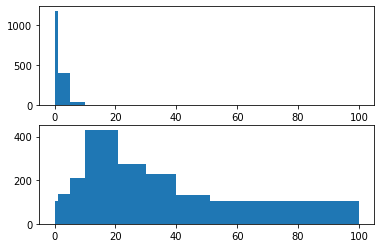

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
(n4, bins, patches) = ax1.hist(Fold1["eosinophil"],[0,1,5,10,21,30,40,51,100])
(n5, bins, patches) = ax2.hist(Fold1["connective"],[0,1,5,10,21,30,40,51,100])
plt.show

**Converting to HED space**

skimage version 0.16.2


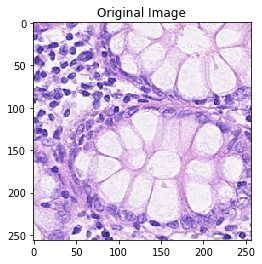

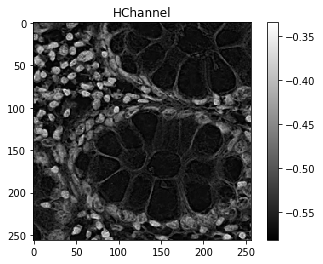

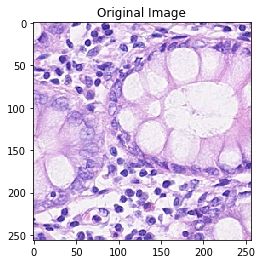

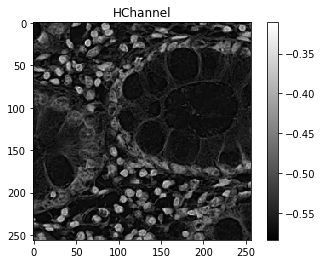

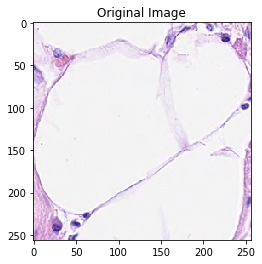

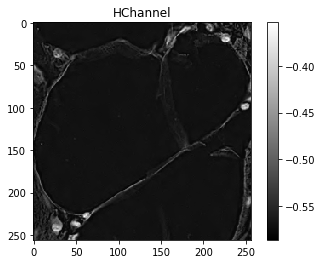

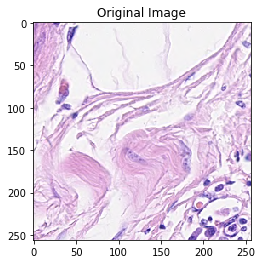

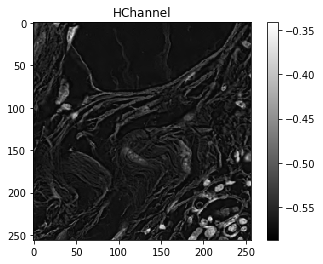

In [ ]:
print('skimage version',skimage.__version__)
for i in range(10,14): #for images 10 - 14 plot original and H channel 
    I = X[i]/255.0 #read sample image and rescale pixel range in it
    I_hed = rgb2hed(I)#convert to HED
    plt.imshow(I);plt.title('Original Image');plt.show()
    I_h = I_hed[:,:,0]; plt.figure(); plt.imshow(I_h,cmap='gray');plt.colorbar();plt.title('HChannel');plt.show()

**Statistical Measures on H-Channel Vs. T3 Cell Count**

Functions to extract average, variance and entropy features of H-channel


In [ ]:
d1 = []
d2 = []
d3 = []
for i in range(len(X)):
    a = X[i]/255.0 
    I_hed1 = rgb2hed(a)
    b = I_hed1[:,:,0]
    c1 = (np.average(b))
    c2 = (np.var(b))
    c3 = (skimage.measure.shannon_entropy(b))
    d1.append(c1)
    d2.append(c2)
    d3.append(c3)
Y.insert(7, "AVG_H", d1)
Y.insert(8, "VAR_H", d2)
Y.insert(9, "ENT_H", d3)

Visualisation of H-channel average against Cell Count of each type

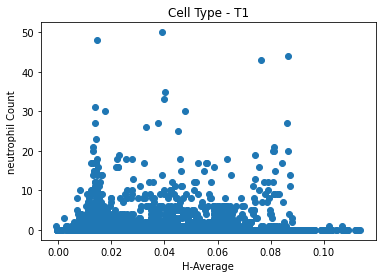

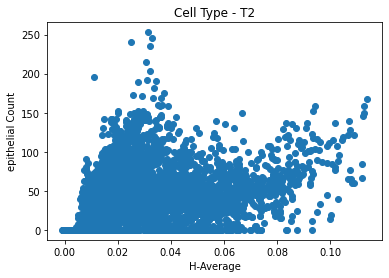

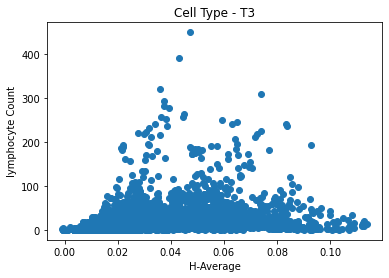

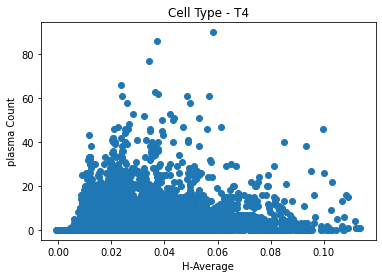

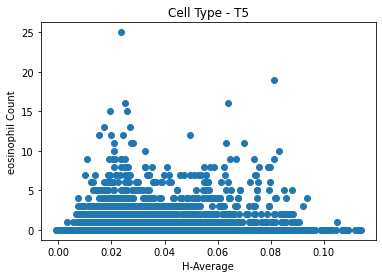

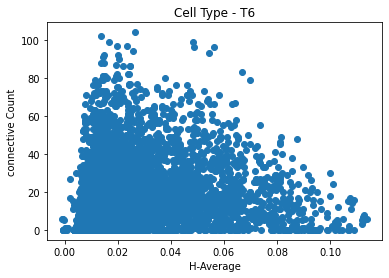

In [ ]:
T_num = 0
for col in Y[['neutrophil', 'epithelial', 'lymphocyte', 'plasma','eosinophil', 'connective']]:
   T_num+=1
   plt.scatter(Y['AVG_H'],Y[f'{col}'])
   plt.xlabel('H-Average')
   plt.ylabel(f'{col} Count')
   plt.title(f'Cell Type - T{T_num}')
   plt.show()

Visualise relationship between each statistical measure of H-channel and number of T3 Cells

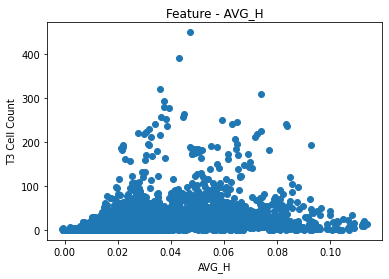

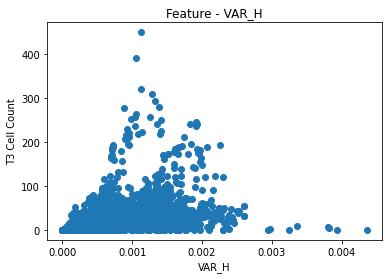

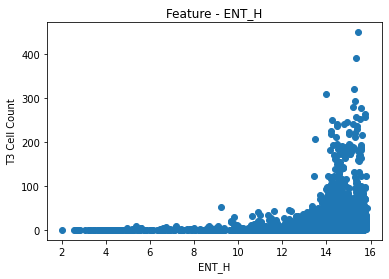

In [ ]:
for col in Y[['AVG_H', 'VAR_H', 'ENT_H']]:
   plt.scatter(Y[f'{col}'],Y['lymphocyte'])
   plt.xlabel(f'{col}')
   plt.ylabel('T3 Cell Count')
   plt.title(f'Feature - {col}')
   plt.show()

Functions to extract GLCM features of images

In [ ]:
e1 = []
e2 = []
e3 = []
e4 = []
e5 = []
e6 = []
for i in range(len(X)):   
    a = X[i] 
    b = rgb2gray(a)
    c = greycomatrix(b.astype(int), distances=[5], angles=[0], levels=256,symmetric=True, normed=True)
    d1 = greycoprops(c, 'dissimilarity')
    d2 = greycoprops(c, 'homogeneity')
    d3 = greycoprops(c, 'ASM')
    d4 = greycoprops(c, 'energy')
    d5 = greycoprops(c, 'correlation')
    d6 = greycoprops(c, 'contrast')
    e1.append(d1)
    e2.append(d2)
    e3.append(d3)
    e4.append(d4)
    e5.append(d5)
    e6.append(d6)

Y.insert(10, 'dissimilarity', e1)
Y.insert(11, 'homogeneity', e2)
Y.insert(12, 'ASM', e3)
Y.insert(13, 'energy', e4)
Y.insert(14, 'correlation', e5)
Y.insert(15, 'contrast', e6)

**Regression Models**

**Creating training and test set accoriding to Folds**

In [ ]:
x = Y[['lymphocyte', 'Fold','AVG_H', 'VAR_H', 'ENT_H', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation', 'contrast']]
x_train = x[x["Fold"] != 3.0]
x_test = x[x["Fold"] == 3.0]
y_train = x_train['lymphocyte']
y_test = x_test['lymphocyte']
x_train = x_train.drop(['Fold','lymphocyte'], axis=1)
x_test = x_test.drop(['Fold','lymphocyte'], axis=1)

RMSE:  27.176670968522366
R2 Score:  -1.1423044727344833
PCC:  0.4723415773824671
SCC:  0.6689279363012018


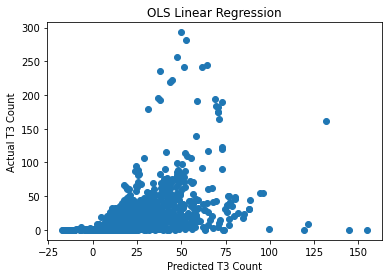

In [ ]:
reg = LinearRegression().fit(x_train, y_train)
test_preds = reg.predict(x_test).flatten()
print('RMSE: ', np.sqrt(mean_squared_error(test_preds, y_test)))
print('R2 Score: ', r2_score(test_preds, y_test))
print('PCC: ', pearsonr(test_preds, y_test)[0])
print('SCC: ', spearmanr(test_preds, y_test)[0])
plt.scatter(test_preds,y_test)
plt.xlabel('Predicted T3 Count')
plt.ylabel('Actual T3 Count')
plt.title('OLS Linear Regression')
plt.show()

**Linear SVR**

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


RMSE:  28.654399054764145
R2 Score:  -25.45641169648042
PCC:  0.33319913851272337
SCC:  0.6130343585597225


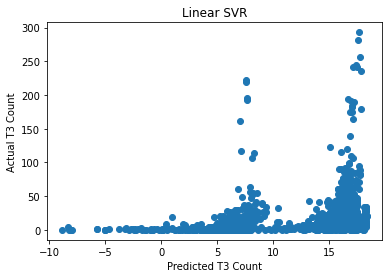

In [ ]:
regr = LinearSVR(random_state=0, tol=1e-5)
regr.fit(x_train, y_train)
test_pred = regr.predict(x_test).flatten()
print('RMSE: ', np.sqrt(mean_squared_error(test_pred, y_test)))
print('R2 Score: ', r2_score(test_pred, y_test))
print('PCC: ', pearsonr(test_pred, y_test)[0])
print('SCC: ', spearmanr(test_pred, y_test)[0])
plt.scatter(test_pred,y_test)
plt.xlabel('Predicted T3 Count')
plt.ylabel('Actual T3 Count')
plt.title('Linear SVR')
plt.show()

**CNN Model**

Create Training and testing folds for CNN Model

In [ ]:
fold_num1 = 1
fold_num2 = 2
fold_num3 = 3

x_train = []
x_val = []
x_test = []
#retrieve images that are in Fold 1 append them into list called x_train
for i in range(X.shape[0]):
    if F[i] == fold_num1:
        x_train.append(X[i])
x_train = np.array(x_train, dtype=np.uint8)
#retrieve images that are in Fold 2 append them into list called x_val
for i in range(X.shape[0]):
    if F[i] == fold_num2:
        x_val.append(X[i])
x_val = np.array(x_val, dtype=np.uint8)
#retrieve images that are in Fold 3 append them into list called x_test
for i in range(X.shape[0]):
    if F[i] == fold_num3:
        x_test.append(X[i])
x_test = np.array(x_test, dtype=np.uint8)

In [ ]:
x_train_cnn = np.concatenate((x_train, x_val), axis=0) #concatenated Fold 1 and Fold 2 images together in that order
y_train_cnn = pd.concat([Fold1["lymphocyte"], Fold2["lymphocyte"]], ignore_index=True) #concatenated Fold 1 and Fold 2 no of T3 cells together in same order

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Reshape, BatchNormalization
from keras.callbacks import EarlyStopping

CNN Novel Architecture through experimentation

In [ ]:
model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(1,))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 254, 254, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 84, 84, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 82, 82, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 82, 82, 32)       128       
 chNormalization)                                                
                                                      

Early stopping for added regularisation of model

Epoch 1/10
29/29 [==============================] - 5s 181ms/step - loss: 26.8033 - val_loss: 247.5508
Epoch 2/10
29/29 [==============================] - 4s 152ms/step - loss: 19.9535 - val_loss: 203.9111
Epoch 3/10
29/29 [==============================] - 4s 151ms/step - loss: 16.2976 - val_loss: 202.9459
Epoch 4/10
29/29 [==============================] - 4s 151ms/step - loss: 16.1151 - val_loss: 187.4437
Epoch 5/10
29/29 [==============================] - 4s 150ms/step - loss: 14.0572 - val_loss: 193.9828
Epoch 6/10
29/29 [==============================] - 4s 151ms/step - loss: 16.8895 - val_loss: 214.8575
Epoch 7/10
29/29 [==============================] - 4s 151ms/step - loss: 11.2233 - val_loss: 182.9412
Epoch 8/10
29/29 [==============================] - 4s 152ms/step - loss: 12.0450 - val_loss: 178.9748
Epoch 9/10
29/29 [==============================] - 4s 152ms/step - loss: 14.7739 - val_loss: 181.1339
Epoch 10/10
29/29 [==============================] - 4s 155ms/step - loss

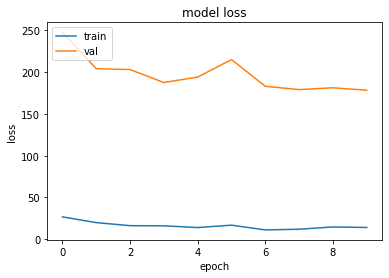

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
history = model.fit(x_train_cnn, y_train_cnn, batch_size = 100, epochs=10,
                    validation_split=0.15, callbacks=[es])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
t_pred = model.predict(x_test).flatten()
print('RMSE: ', np.sqrt(mean_squared_error(t_pred, Fold3["lymphocyte"])))
print('R2 Score: ', r2_score(t_pred, Fold3["lymphocyte"]))
print('PCC: ', pearsonr(t_pred, Fold3["lymphocyte"])[0])
print('SCC: ', spearmanr(t_pred, Fold3["lymphocyte"])[0])

RMSE:  16.45662518872666
R2 Score:  0.4254063247456753
PCC:  0.8381031957797842
SCC:  0.8001676801211351
